In [ ]:
!tar -xvzf /content/drive/MyDrive/detection.tar.gz

In [ ]:
!mkdir -p /content/data/images/train
!mkdir -p /content/data/labels/train
!mkdir -p /content/data/images/val
!mkdir -p /content/data/labels/val
!mkdir -p /content/data/images/test
!mkdir -p /content/data/labels/test

In [ ]:
!mkdir labels

**GENERATE APPLE COUNT DATASET**

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
import re

#Modified from source(Official Minneapple Repo): https://github.com/nicolaihaeni/MinneApple

class AppleDataset(object):
    def __init__(self, root_dir, save_dir, transforms):
        self.root_dir = root_dir
        self.save_dir = save_dir
        self.transforms = transforms

        # Load all image and mask files, sorting them to ensure they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root_dir, "masks"))))

    def get_item(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root_dir, "images", self.imgs[idx])
        mask_path = os.path.join(self.root_dir, "masks", self.masks[idx])

        img_name_indl = img_path.rfind("/") + 1
        img_name_indr = img_path.rfind(".")

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)     # Each color of mask corresponds to a different instance with 0 being the background

        # Convert the PIL image to np array
        mask = np.array(mask)
        obj_ids = np.unique(mask)

        # Remove background id
        obj_ids = obj_ids[1:]

        # Split the color-encoded masks into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # Get bbox coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        h, w = mask.shape

        for ii in range(num_objs):
            pos = np.where(masks[ii])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if xmin == xmax or ymin == ymax:
                continue

            xmin = np.clip(xmin, a_min=0, a_max=w)
            xmax = np.clip(xmax, a_min=0, a_max=w)
            ymin = np.clip(ymin, a_min=0, a_max=h)
            ymax = np.clip(ymax, a_min=0, a_max=h)

            xc = float(((xmin + xmax)/2)/w)
            yc = float(((ymin + ymax)/2)/h)
            width =  float(((xmax - xmin))/w)
            height = float((ymax - ymin)/h)
#            print(xmin, xmax, ymin, ymax)
            boxes.append([xc, yc, width, height])

        with open(self.save_dir + img_path[img_name_indl:img_name_indr] + ".txt", "w") as f:
            no_boxes = len(boxes)
            coord = str(no_boxes)
            f.write(coord)


    def __len__(self):
          return len(self.imgs)

    def get_img_name(self, idx):
          return self.imgs[idx]

if __name__ == "__main__":
    dataset_path = "/content/detection/train"
    save_directory = "/content/labels/"

    dataset = AppleDataset(root_dir=dataset_path, save_dir = save_directory, transforms=None)

    num_images_to_process = min(1000, len(dataset))
    for i in range(num_images_to_process):
      dataset.get_item(i)

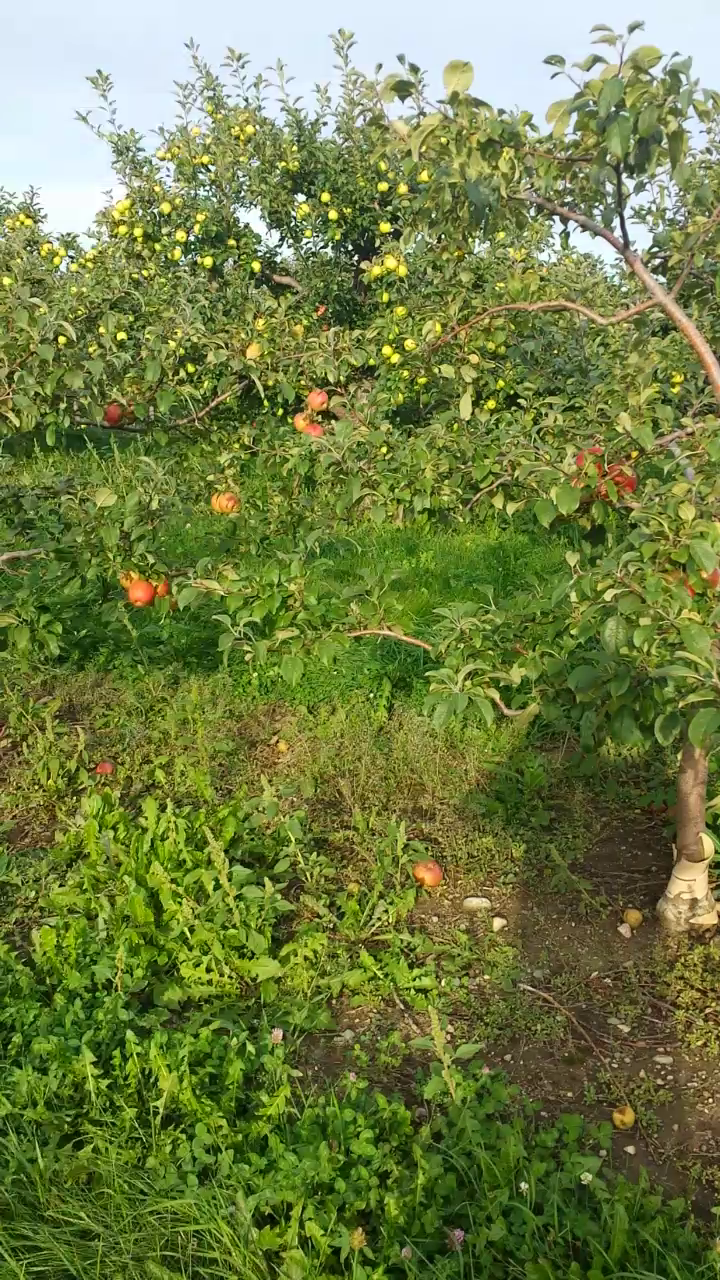

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/detection/train/images/20150919_174730_image151.png")
cv2_imshow(img)

In [ ]:
!mkdir images_data
!cp /content/detection/train/images/* /content/images_data

In [ ]:
!zip -r count_labels.zip labels

In [ ]:
!unzip /content/drive/MyDrive/labels.zip -d labels

In [ ]:
!mkdir labels_data
!cp labels/content/data/labels/train/* labels_data

**Split into Train, Validation, Test**

In [ ]:
import os
import shutil
from random import shuffle

name_list = [f for f in os.listdir("/content/images_data/")]
shuffle(name_list)

print(len(name_list))

dataset_len = len(name_list)
train_num = int(dataset_len * 0.8)
val_num = int(dataset_len * 0.1)
test_num = int(dataset_len * 0.1)

train_list = name_list[0:train_num]
val_list = name_list[train_num: train_num + val_num]
test_list = name_list[train_num + val_num:]

for fname in train_list:
    shutil.copy("/content/images_data/"+fname, "/content/data/images/train/"+fname)

for fname in val_list:
    shutil.copy("/content/images_data/"+fname, "/content/data/images/val/"+fname)

for fname in test_list:
    shutil.copy("/content/images_data/"+fname, "/content/data/images/test/"+fname)


for fname in train_list:
    fname_indl = fname.rfind("/") + 1
    fname_indr = fname.rfind(".")
    fname = fname[fname_indl:fname_indr]+".txt"
    shutil.copy("/content/labels_data/"+fname, "/content/data/labels/train/"+fname)

for fname in val_list:
    fname_indl = fname.rfind("/") + 1
    fname_indr = fname.rfind(".")
    fname = fname[fname_indl:fname_indr]+".txt"
    shutil.copy("/content/labels_data/"+fname, "/content/data/labels/val/"+fname)

for fname in test_list:
    fname_indl = fname.rfind("/") + 1
    fname_indr = fname.rfind(".")
    fname = fname[fname_indl:fname_indr]+".txt"
    shutil.copy("/content/labels_data/"+fname, "/content/data/labels/test/"+fname)

670


In [ ]:
!zip -r yolo_apple_data.zip data